In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow import keras
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.python.framework import ops
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
from tensorflow import keras
import sys
import cv2
from tensorflow.keras.models import load_model
import json
import dlib
from PIL import Image
tf.compat.v1.disable_eager_execution()


In [ ]:
with open("./config/parameters.json") as f:
    data = json.load(f)
f.close()

model_param = data["model_param"]
lr, epochs, batch_size, mapping_path, save_path, log_path = model_param.values()

with open(mapping_path) as f:
    mapping = json.load(f)
f.close()

In [ ]:
model_param

In [ ]:
mapping

In [ ]:
def detect_face(image_path, im_size = 224, default_max_size=800,size = 300, padding = 0.25):
    cnn_face_detector = dlib.cnn_face_detection_model_v1('./dlib_mod/mmod_human_face_detector.dat')
    sp = dlib.shape_predictor('./dlib_mod/shape_predictor_5_face_landmarks.dat')
    base = 2000  # largest width and height

    img = dlib.load_rgb_image(image_path)
    old_height, old_width, _ = img.shape
    old_height, old_width, _ = img.shape

    if old_width > old_height:
        new_width, new_height = default_max_size, int(default_max_size * old_height / old_width)
    else:
        new_width, new_height =  int(default_max_size * old_width / old_height), default_max_size
    img = dlib.resize_image(img, rows=new_height, cols=new_width)
    dets = cnn_face_detector(img, 1)
    num_faces = len(dets)
    if num_faces == 0:
        print("Sorry, there were no faces found in '{}'".format(image_path))
        return
    elif num_faces > 1:
        print("Multiple face in '{}'. A random face will be returned".format(image_path))
    faces = dlib.full_object_detections()
    for detection in dets:
        rect = detection.rect
        faces.append(sp(img, rect))
    image = dlib.get_face_chips(img, faces, size=size, padding = padding)[0]

    image = Image.fromarray(image, 'RGB')
    image = image.resize((im_size, im_size))

    return image

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv2d_7'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = load_model(save_path)
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #if K.image_dim_ordering() == 'th':
    #    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam(input_model, image, category_index, layer_name):
    model = input_model

    nb_classes = 7
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    #conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    conv_output =  [l for l in model.layers if l.name == layer_name][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam / 255) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap, image
    #return cam, heatmap, image

In [ ]:
model = load_model(save_path)

In [ ]:
model.summary()

### NOTE

If you want to input your own image(i.e. images that are not from the FairFace), please uncomment the last line in load_image function and comment out the rest(except the first line)

* After you run the code below, it will generate two images: one for grad-cam and one for guided grad-cam. 

In [ ]:
sample_img = '/teams/DSC180A_FA20_A00/a01explainableai/a01capstonegroup03/fairface_pad025/val/7.jpg'
#sample_img = "./IMG_5321.jpg"
preprocessed_input = load_image(sample_img)
predictions = model.predict(preprocessed_input)
predicted_class = np.argmax(predictions)
cam, heatmap, img = grad_cam(model, preprocessed_input, predicted_class, "conv2d_7")
cv2.imwrite("./gradcam_7_my.jpg", cam)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("./guided_gradcam_7_my.jpg", deprocess_image(gradcam))

### Experiment

In [ ]:
import os
def grad_cam_v2(PIL_img, target, lookup = None):
    #loading models and params
    if target == "race":
        model_path = "./models/race/race_v6.hdf5"
    elif target == "age":
        model_path = "./models/age/age_v1.hdf5"
    else:
        model_path = "./models/gender/gender_v6.hdf5"
    
    model = load_model(model_path)
    nb_classes = model.output.shape[1]
    
    #read the mapping
    mapping = os.path.join("./mapping", target + ".json")
    with open(mapping) as f:
        mapping_dict = json.load(f)
    f.close()
    
    mapping_dict = {key.lower():val for key, val in mapping_dict.items()}
    mapping_dict_rev = {val:key for key, val in mapping_dict.items()}
    
    
    #preprocess image
    PIL_img = np.array(PIL_img).astype("float32")[None, :]
    image = resnet_v2.preprocess_input(PIL_img)
    
    #inference 
    if lookup == None:
        output_prob = model.predict(PIL_img).squeeze()
        pred_idx = output_prob.argmax()
    else:
        lookup = lookup.lower()
        pred_idx = mapping_dict[lookup]
    
    #grad_cam
    target_layer = lambda x: target_category_loss(x, pred_idx, nb_classes)
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    conv_output =  [l for l in model.layers if l.name == "conv2d_7"][0].output
    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam / 255) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam)

In [1]:
import sys
sys.path.append("./src")
from grad_cam import *
import PIL.Image as Image
sample_img = '/teams/DSC180A_FA20_A00/a01explainableai/a01capstonegroup03/fairface_pad025/val/7.jpg'
img = Image.open(sample_img)
cam, guided = grad_cam(img, "race")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


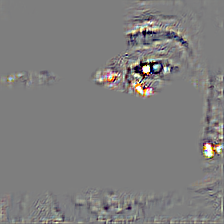

In [4]:
guided

In [ ]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]

In [ ]:
guided = deprocess_image(gradcam)

In [ ]:
Image.fromarray(guided)

In [ ]:
Image.fromarray(np.uint8(gradcam))

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(gradcam.squeeze())